In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
import pandas as pd
from pyprojroot import here
import numpy as np
os.environ['KAGGLEHUB_CACHE'] = str(here("data"))
import kagglehub

path = kagglehub.dataset_download("datamunge/sign-language-mnist")
test_pd = pd.read_csv(os.path.join(path, "sign_mnist_test/sign_mnist_test.csv"))
train_pd = pd.read_csv(os.path.join(path, "sign_mnist_train/sign_mnist_train.csv"))
test_pd

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7167,1,135,119,108,102,105,99,61,103,121,...,108,112,116,114,118,180,184,176,167,163
7168,12,157,159,161,164,166,166,171,174,175,...,213,213,213,214,213,211,210,210,209,208
7169,2,190,191,190,191,190,190,192,192,191,...,216,215,213,214,214,213,210,211,209,208
7170,4,201,205,208,209,214,216,218,223,226,...,112,169,255,255,237,113,91,67,70,63


In [2]:
os.environ['TORCH_HOME'] = str(here("cache"))
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
from sklearn.model_selection import train_test_split
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

class SignMNIST(Dataset):
  def __init__(self, df: pd.DataFrame):
    self.df = df
    self.target: np.array = self.df["label"].values
    self.data = self.df.drop(columns=["label"]).values
    self.data = self.data.reshape(self.data.shape[0], 28, 28)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: list[int]) -> tuple:
    image = self.data[index]  # shape (28, 28)

    image = image.astype(np.float32) / 255.0  # min max Normalize to [0, 1]
    image = torch.tensor(image) 
    image = image.unsqueeze(0) # Add channel dimension (C x H x W)
    image = torchvision.transforms.functional.resize(image, (224, 224))
    
    
    label = self.target[index]
    label = torch.tensor(label, dtype=torch.int64, device=DEVICE)

    return image, label

  @staticmethod
  def label_to_letter(label: int) -> str:
    return chr(label + 65)

  @property
  def shape(self) -> tuple:
    return self.data.shape, self.target.shape
  
keras.utils.set_random_seed(1)
train_pd_split, val_pd = train_test_split(train_pd, test_size=0.1, stratify=None)

train_dataloader = DataLoader(
  train := SignMNIST(train_pd_split),
  batch_size=32,
  shuffle=True,
  # num_workers=15
)
val_dataloader = DataLoader(
  val := SignMNIST(val_pd),
  batch_size=32,
  shuffle=False,
  # num_workers=15,
  # persistent_workers=True
)
test_dataloader = DataLoader(
  test := SignMNIST(test_pd),
  batch_size=32,
  shuffle=False,
  # num_workers=15,
)
train_dataloader

In [3]:
model = torchvision.models.alexnet(weights="DEFAULT")
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [4]:
from torchinfo import summary
from collections import namedtuple
Shape = namedtuple("Shape", ["batchsize", "channels", "height", "width"])	
summary(model, Shape(batchsize=64, channels=3, height=224, width=224), device="cuda")


Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [64, 1000]                --
├─Sequential: 1-1                        [64, 256, 6, 6]           --
│    └─Conv2d: 2-1                       [64, 64, 55, 55]          23,296
│    └─ReLU: 2-2                         [64, 64, 55, 55]          --
│    └─MaxPool2d: 2-3                    [64, 64, 27, 27]          --
│    └─Conv2d: 2-4                       [64, 192, 27, 27]         307,392
│    └─ReLU: 2-5                         [64, 192, 27, 27]         --
│    └─MaxPool2d: 2-6                    [64, 192, 13, 13]         --
│    └─Conv2d: 2-7                       [64, 384, 13, 13]         663,936
│    └─ReLU: 2-8                         [64, 384, 13, 13]         --
│    └─Conv2d: 2-9                       [64, 256, 13, 13]         884,992
│    └─ReLU: 2-10                        [64, 256, 13, 13]         --
│    └─Conv2d: 2-11                      [64, 256, 13, 13]        

In [5]:
import lightning as L
import torchvision.transforms as transforms
from collections import namedtuple

Metrics = namedtuple("Metrics", ["loss", "accuracy"])

class ReconstructedAlexNet(L.LightningModule):
  def __init__(self, model: torch.nn.Module):
    super().__init__()
    self.model = model
    self.results: list[Metrics] = []
    self._results_epoch: list[Metrics] = []
    with torch.no_grad():
      # change out to 26 classes
      self.model.classifier[6] = torch.nn.Linear(4096, 26) # 26 letters of the alphabet
      
      # change in to 1 channel and keep weights somewhat similar
      trained_inp_layer = self.model.features[0]
      new_inp_layer = torch.nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      new_inp_layer.weight.data = trained_inp_layer.weight.data.mean(dim=1, keepdim=True)
      new_inp_layer.bias.data = trained_inp_layer.bias.data
      model.features[0] = new_inp_layer
      
      # freeze only features layers
      for param in self.model.features.parameters():
        param.requires_grad = False
      model.features[0].weight.requires_grad = True
      model.features[0].bias.requires_grad = True
      
      # reconstruct classifier layers / reset weights
      for layer in self.model.classifier.children():
        if isinstance(layer, torch.nn.Linear):
          layer.reset_parameters()

  def training_step(self, batch, batch_idx):
    x, _ = batch
    y = self.model(x)
    loss = torch.nn.functional.cross_entropy(y, _)
    return loss
  
  def validation_step(self, batch, batch_idx):
    x, _ = batch
    y = self.model(x)
    loss = torch.nn.functional.cross_entropy(y, _)
    self.log("val_loss", loss, prog_bar=True)
    acc = (y.argmax(dim=1) == _).float().mean()
    self.log("val_acc", acc, prog_bar=True)
    self._results_epoch.append(Metrics(loss.item(), acc.item()))
    
  def on_validation_epoch_start(self):
    self._results_epoch = []
  def on_validation_epoch_end(self):
    self.results.append(Metrics(
      np.mean([m.loss for m in self._results_epoch]),
      np.mean([m.accuracy for m in self._results_epoch])
    ))
    self._results_epoch = []
  def test_step(self, batch, batch_idx):
    x, _ = batch
    y = self.model(x)
    loss = torch.nn.functional.cross_entropy(y, _)
    self.log("test_loss", loss, prog_bar=True)
    acc = (y.argmax(dim=1) == _).float().mean()
    self.log("test_acc", acc, prog_bar=True)
  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=1e-3)
    
reconstructed_alex_net = ReconstructedAlexNet(model)
reconstructed_alex_net

ReconstructedAlexNet(
  (model): AlexNet(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=Fal

In [6]:
torch.set_float32_matmul_precision('high')
keras.utils.set_random_seed(1)
trainer = L.Trainer(
  max_epochs=10,
  default_root_dir=str(here("cache")),
  enable_checkpointing=False,
)
out = trainer.fit(
  model=reconstructed_alex_net, 
  train_dataloaders=train_dataloader, 
  val_dataloaders=val_dataloader
)
out

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Plancha\AML-homework\.pixi\envs\gpu\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type    | Params | Mode 
------------------------------------------
0 | model | AlexNet | 57.1 M | train
------------------------------------------
54.6 M    Trainable params
2.4 M     Non-trainable params
57.1 M    Total params
228.379   Total estimated model params size (MB)
24  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Plancha\AML-homework\.pixi\envs\gpu\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\Plancha\AML-homework\.pixi\envs\gpu\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [7]:
out_test = trainer.test(model=reconstructed_alex_net, dataloaders=test_dataloader)
out_test

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Plancha\AML-homework\.pixi\envs\gpu\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9541271328926086     │
│         test_loss         │    0.1857084482908249     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.1857084482908249, 'test_acc': 0.9541271328926086}]

In [8]:
reconstructed_alex_net.results

[Metrics(loss=np.float64(3.2617595195770264), accuracy=np.float64(0.015625)),
 Metrics(loss=np.float64(0.6887927790020787), accuracy=np.float64(0.7851911901041518)),
 Metrics(loss=np.float64(0.4215722848163095), accuracy=np.float64(0.8599619858486708)),
 Metrics(loss=np.float64(0.31851959497083066), accuracy=np.float64(0.9319655638794566)),
 Metrics(loss=np.float64(0.1778138607827037), accuracy=np.float64(0.9661225406236427)),
 Metrics(loss=np.float64(0.11650579019861165), accuracy=np.float64(0.9903846161310063)),
 Metrics(loss=np.float64(0.09413086434523034), accuracy=np.float64(0.9916424418604651)),
 Metrics(loss=np.float64(0.10915333758173294), accuracy=np.float64(0.9781138196934102)),
 Metrics(loss=np.float64(0.11920791800502081), accuracy=np.float64(0.9836482558139535)),
 Metrics(loss=np.float64(0.11645712818257338), accuracy=np.float64(0.9890988372093024)),
 Metrics(loss=np.float64(0.06218429105789509), accuracy=np.float64(0.9930959302325582))]

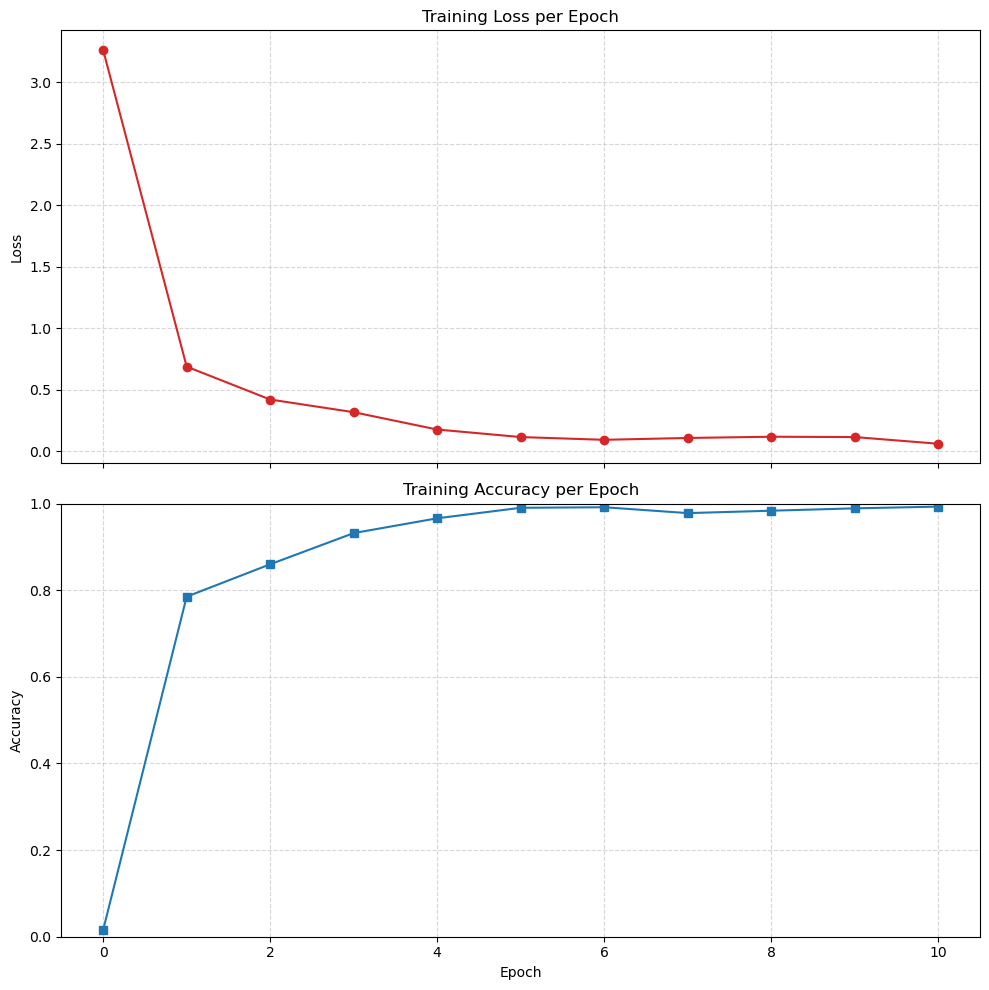

In [9]:
metrics = pd.DataFrame(
  [(i, m.loss, m.accuracy) for i, m in enumerate(reconstructed_alex_net.results)],
  columns=["epoch", "loss", "accuracy"]
).set_index("epoch")
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# Plot Loss
axes[0].plot(metrics.index, metrics["loss"], marker='o', color='tab:red')
axes[0].set_ylabel("Loss")
axes[0].set_title("Training Loss per Epoch")
axes[0].grid(True, linestyle='--', alpha=0.5)

# Plot Accuracy
axes[1].plot(metrics.index, metrics["accuracy"], marker='s', color='tab:blue')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Training Accuracy per Epoch")
axes[1].set_ylim(0, 1)  # Show accuracy between 0 and 1
axes[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [10]:
# save model
torch.save(reconstructed_alex_net.state_dict(), str(here("cache", "reconstructed_alex_net.pth")))

RuntimeError: File c:\Users\Plancha\AML-homework\cache cannot be opened.

The reconstructed layers reached a lower loss earlier, showing a better performance for finetuning. Since only one layer was reset and not frozen from the freeze_alexnet, the training time and acuracy was similar